In [ ]:
import kagglehub
import pandas as pd
import os

# Download latest version
path = kagglehub.dataset_download("sadmansakib7/ecg-arrhythmia-classification-dataset")

file_name = 'MIT-BIH Arrhythmia Database.csv'
full_path = os.path.join(path, file_name)

print("Full path to file:", full_path)


# load the dataset
df = pd.read_csv(full_path)



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# This code block is for the data exploration and visualization

# N (Normal):
# Description: Represents normal heartbeats. These are the most common and indicate a regular, healthy heartbeat pattern.
# Count: 90,083 instances in your dataset, indicating that normal heartbeats are the majority class.
# VEB (Ventricular Ectopic Beat):
# Description: These are premature heartbeats originating from the ventricles.
# Count: 7,009 instances, making it a minority class compared to normal beats.
# SVEB (Supraventricular Ectopic Beat):
# Description: These are premature heartbeats originating above the ventricles, often in the atria.
# Count: 2,779 instances, another minority class.
# F (Fusion Beat):
# Description: Fusion beats occur when a normal heartbeat and an ectopic beat occur at the same time
# Count: 803 instances, indicating it's a relatively rare occurrence in your dataset.
# Q (Unknown/Unclassified):
# Description: This category might represent beats that couldn't be classified into the other categories
# Count: 15 instances, making it the rarest class in your dataset, should be removed

# ------------------
# Basic Data Visualization
# ------------------

# Bar chart of class distribution
df['type'].value_counts().plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Heartbeat Type')
plt.ylabel('Count')
plt.show()

# Data exploration
print(f'Dataset Shape: {df.shape}\n')
print(df.head(5))
df.info()
df.describe()

# Columns in dataset:
print(df.columns)
print(df['type'].value_counts())

# ------------------
# Univariate Analysis: Distribution of Each Feature
# ------------------
for col in df.select_dtypes(include=['float64', 'int64']).columns:
    if col != 'type':
        plt.figure(figsize=(6,4))
        sns.histplot(df[col], kde=True, bins=30)
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.show()



# from the visualization, we can see that there are some classes with very few samples, and classes that don't do anything
if 'record' in df.columns:
    df = df.drop(columns=['record'])

# drop type ==  Q, not enough samples to form worthwhile predictions
df = df[df['type'] != 'Q']

# Encode the 'type' column,  because the classes are not ordinal
label_encoder = LabelEncoder()
df['type'] = label_encoder.fit_transform(df['type'])
df = df.dropna()

# Print the mapping of classes to encoded values
print(dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

# ------------------
# Correlation Heatmap After Dropping Features
# ------------------
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(), annot=False, cmap='coolwarm')
plt.title('Feature Correlation (After Dropping Features)')
plt.show()

# ==========================
# Multivariate Analysis
# ==========================

# 1. Pairplot for selected important features

selected_features = ['0_qt_interval', '0_pq_interval', '0_qrs_interval', 'type']
sns.pairplot(df[selected_features], hue='type')
plt.suptitle('Pairplot of Selected Features', y=1.02)
plt.show()

# 2. Scatter plot between two key features
plt.figure(figsize=(10,8))
sns.scatterplot(
    data=df,
    x='0_pre-RR',
    y='0_post-RR',
    color='cyan',    # Pick a single color for all dots
    alpha=0.7,
    edgecolor=None
)
plt.title('0_pre-RR vs 0_post-RR (No Legend)', fontsize=16)
plt.xlabel('0_pre-RR Interval (ms)', fontsize=14)
plt.ylabel('0_post-RR Interval (ms)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.3)

# Disable the legend here
plt.legend([],[], frameon=False)

plt.show()
# 3. Boxplots to examine feature distributions across types
for col in ['0_qt_interval', '0_pq_interval', '0_qrs_interval']:
    plt.figure(figsize=(6,4))
    sns.boxplot(x='type', y=col, data=df)
    plt.title(f'{col} by Type')
    plt.show()

# Split the data into features (X) and target (y)
# X contains all columns except 'type', which is our target variable
# y contains only the 'type' column which has been encoded to numeric values
X = df.drop('type', axis=1)
y = df['type']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9, random_state=42)

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both training and test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply SMOTE to the training data, to balance the classes
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

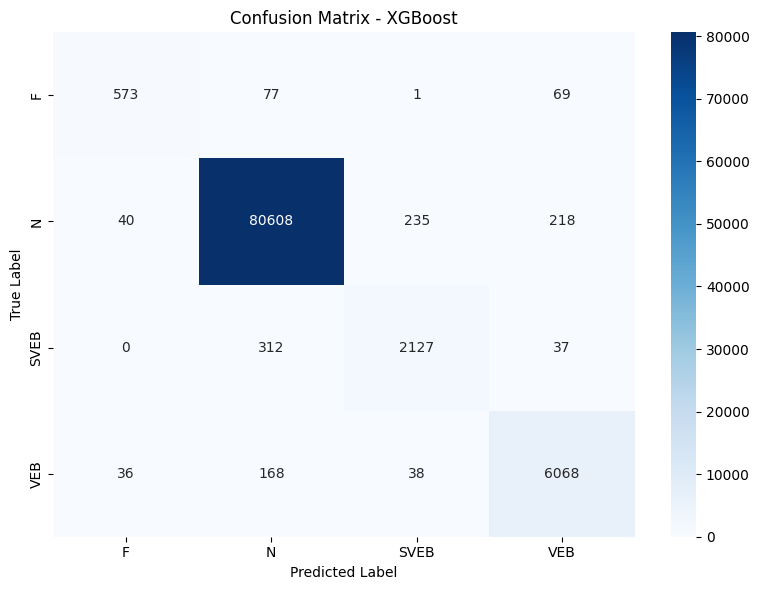

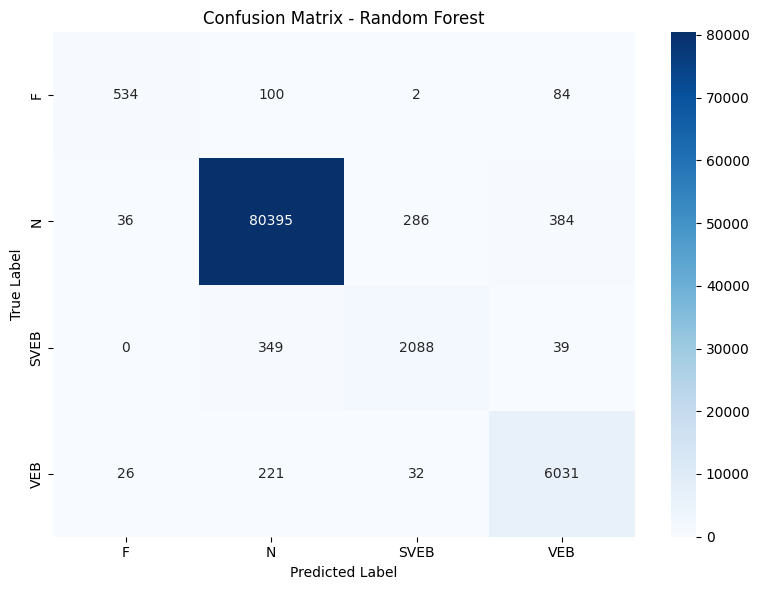

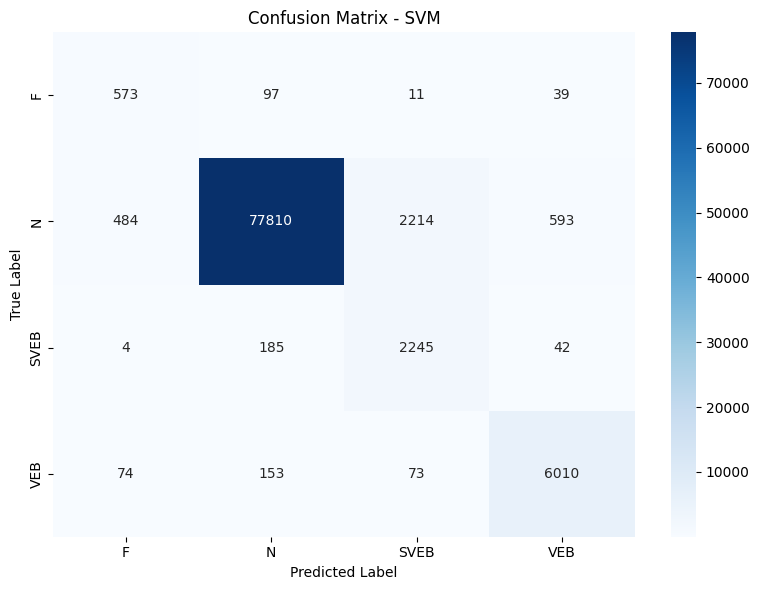

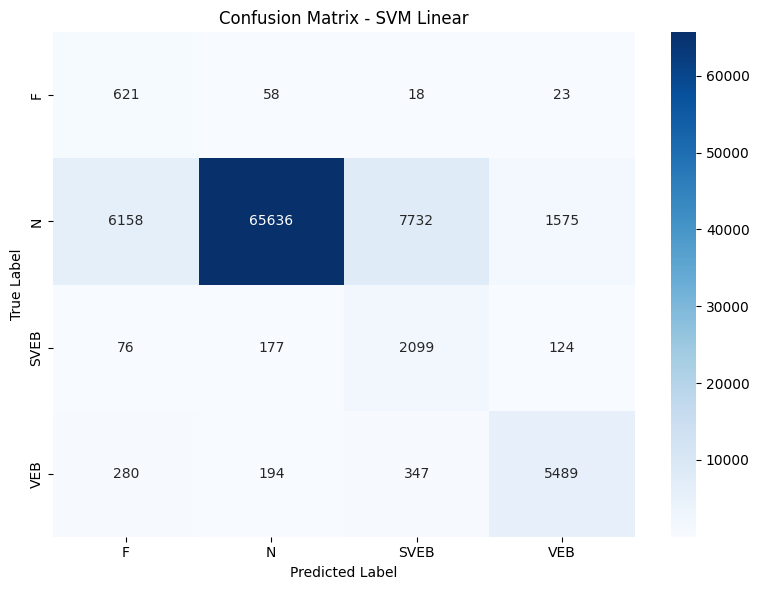

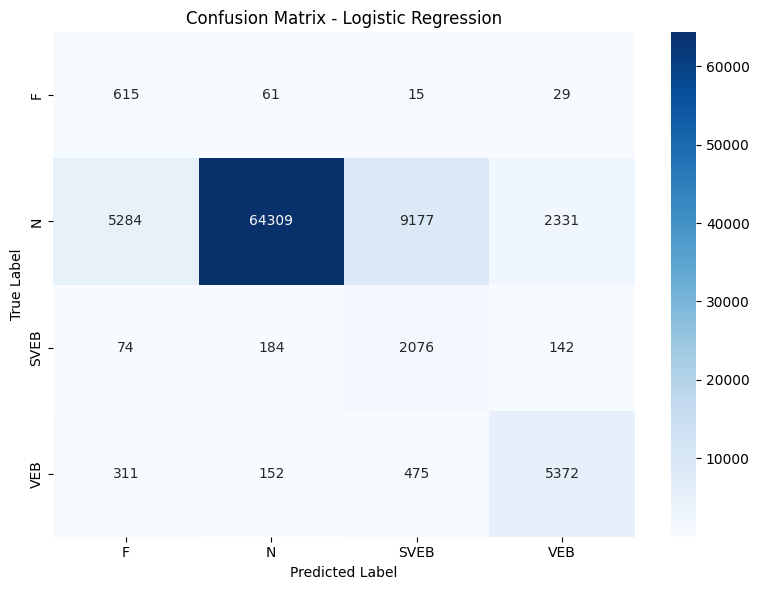

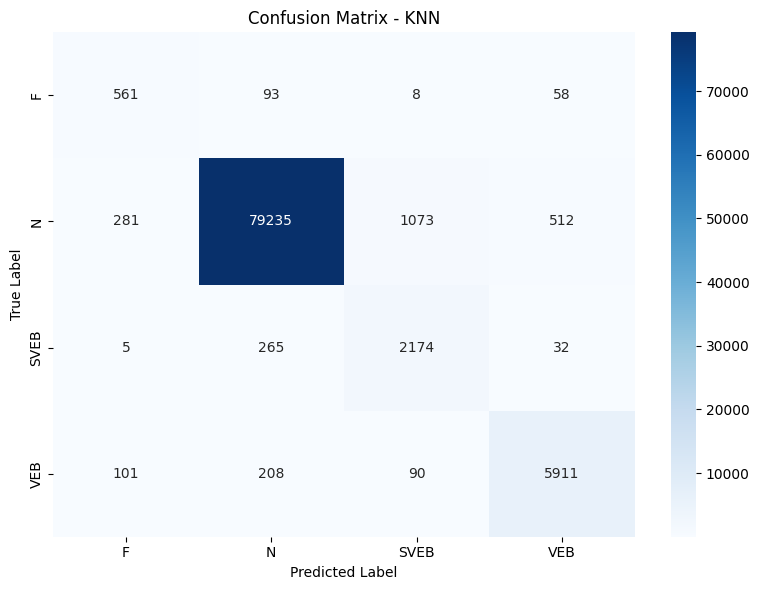

Model Results sorted by weighted f1-score:

XGBoost Results:
              precision    recall  f1-score   support

           F       0.88      0.80      0.84       720
           N       0.99      0.99      0.99     81101
        SVEB       0.89      0.86      0.87      2476
         VEB       0.95      0.96      0.96      6310

    accuracy                           0.99     90607
   macro avg       0.93      0.90      0.91     90607
weighted avg       0.99      0.99      0.99     90607

Weighted F1-Score: 0.9863

Random Forest Results:
              precision    recall  f1-score   support

           F       0.90      0.74      0.81       720
           N       0.99      0.99      0.99     81101
        SVEB       0.87      0.84      0.86      2476
         VEB       0.92      0.96      0.94      6310

    accuracy                           0.98     90607
   macro avg       0.92      0.88      0.90     90607
weighted avg       0.98      0.98      0.98     90607

Weighted F1-Score: 

In [5]:
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier

# This code block is foor all the individual baseline models
model_results = {}

# Add this helper function for plotting confusion matrices
def plot_confusion_matrix(y_true, y_pred, title, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title(f'Confusion Matrix - {title}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

# Function to get weighted avg f1-score from classification report
def get_weighted_f1(y_true, y_pred):
    report = classification_report(y_true, y_pred, target_names=label_encoder.classes_, output_dict=True)
    return report['weighted avg']['f1-score']

# Initialize XGBoost classifier with specific parameters
# use_label_encoder=False: Avoid using the deprecated label encoder
# eval_metric='mlogloss': Use multiclass log loss as evaluation metric
# verbosity=0: Suppress verbose output
# random_state=42: Set seed for reproducibility
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', verbosity=0, random_state=42)

# Train the XGBoost model on the training data
xgb_model.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test data
y_pred_xgb = xgb_model.predict(X_test_scaled)

# Use the original class names from the label encoder for better readability in the report
model_results['XGBoost'] = {'report': classification_report(y_test, y_pred_xgb, target_names=label_encoder.classes_),
                           'weighted_f1': get_weighted_f1(y_test, y_pred_xgb)}

plot_confusion_matrix(y_test, y_pred_xgb, 'XGBoost', label_encoder.classes_)

# Initialize Random Forest classifier with specific parameters
# n_estimators=25: Use 25 trees in the forest
# random_state=42: Set seed for reproducibility
rf_model = RandomForestClassifier(n_estimators=25, random_state=42, n_jobs=-1)

# Train the Random Forest model on the training data
rf_model.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test data
y_pred_rf = rf_model.predict(X_test_scaled)

# Print the classification report
model_results['Random Forest'] = {'report': classification_report(y_test, y_pred_rf, target_names=label_encoder.classes_),
                                  'weighted_f1': get_weighted_f1(y_test, y_pred_rf)}

plot_confusion_matrix(y_test, y_pred_rf, 'Random Forest', label_encoder.classes_)
# Initialize the SVM classifier with RBF kernel for non-linear data
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)

# Train the SVM model on the resampled training data
svm_model.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test data
y_pred_svm = svm_model.predict(X_test_scaled)

# Evaluate the model
model_results['SVM'] = {'report': classification_report(y_test, y_pred_svm, target_names=label_encoder.classes_),
                        'weighted_f1': get_weighted_f1(y_test, y_pred_svm)}

plot_confusion_matrix(y_test, y_pred_svm, 'SVM', label_encoder.classes_)

# Now, a SVM classifier with linear kernel
svm_linear_model = SVC(kernel='linear', C=1.0, random_state=42)

# Train the SVM model on the resampled training data
svm_linear_model.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test data
y_pred_svm_linear = svm_linear_model.predict(X_test_scaled)

# Evaluate the model
model_results['SVM Linear'] = {'report': classification_report(y_test, y_pred_svm_linear, target_names=label_encoder.classes_),
                               'weighted_f1': get_weighted_f1(y_test, y_pred_svm_linear)}

plot_confusion_matrix(y_test, y_pred_svm_linear, 'SVM Linear', label_encoder.classes_)
#Logistic Regression
logistic_model = LogisticRegression(random_state=42, max_iter=1000)

# Train the Logistic Regression model on the resampled training data
logistic_model.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test data
y_pred_logistic = logistic_model.predict(X_test_scaled)

# Evaluate the model
model_results['Logistic Regression'] = {'report': classification_report(y_test, y_pred_logistic, target_names=label_encoder.classes_),
                                        'weighted_f1': get_weighted_f1(y_test, y_pred_logistic)}

plot_confusion_matrix(y_test, y_pred_logistic, 'Logistic Regression', label_encoder.classes_)

# KNN
knn_model = KNeighborsClassifier(n_neighbors=5)

# Train the KNN model on the resampled training data
knn_model.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test data
y_pred_knn = knn_model.predict(X_test_scaled)

# Evaluate the model
model_results['KNN'] = {'report': classification_report(y_test, y_pred_knn, target_names=label_encoder.classes_),
                        'weighted_f1': get_weighted_f1(y_test, y_pred_knn)}

plot_confusion_matrix(y_test, y_pred_knn, 'KNN', label_encoder.classes_)

# Sort the model results by weighted f1-score
sorted_model_results = sorted(model_results.items(), key=lambda x: x[1]['weighted_f1'], reverse=True)

# Print the results
print("Model Results sorted by weighted f1-score:")
for model, result in sorted_model_results:
    print(f"\n{model} Results:")
    print(result['report'])
    print(f"Weighted F1-Score: {result['weighted_f1']:.4f}")


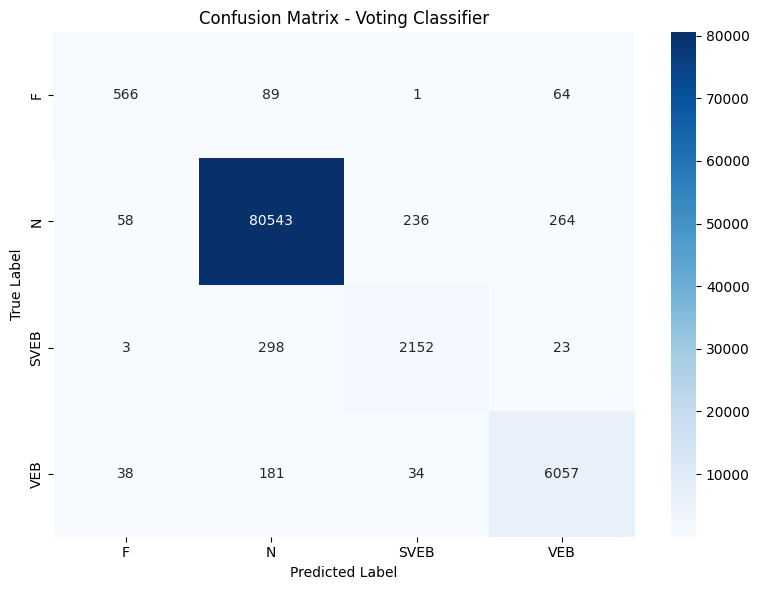

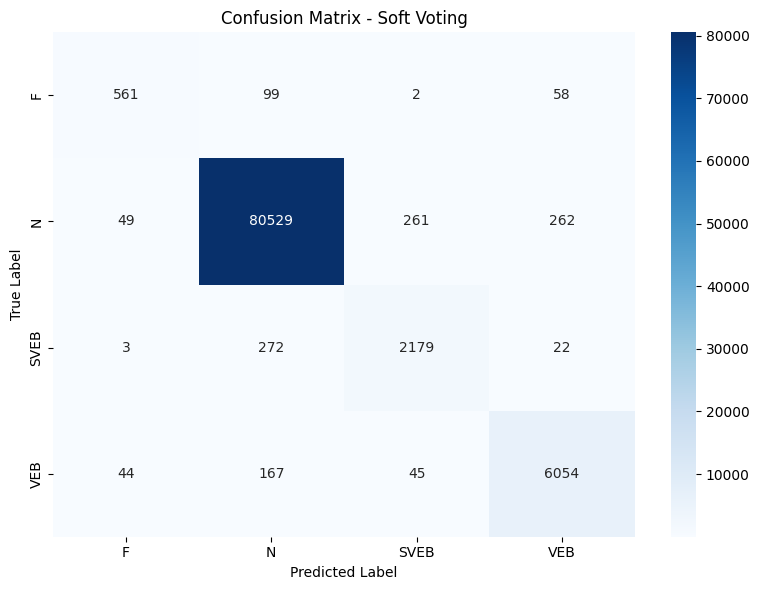

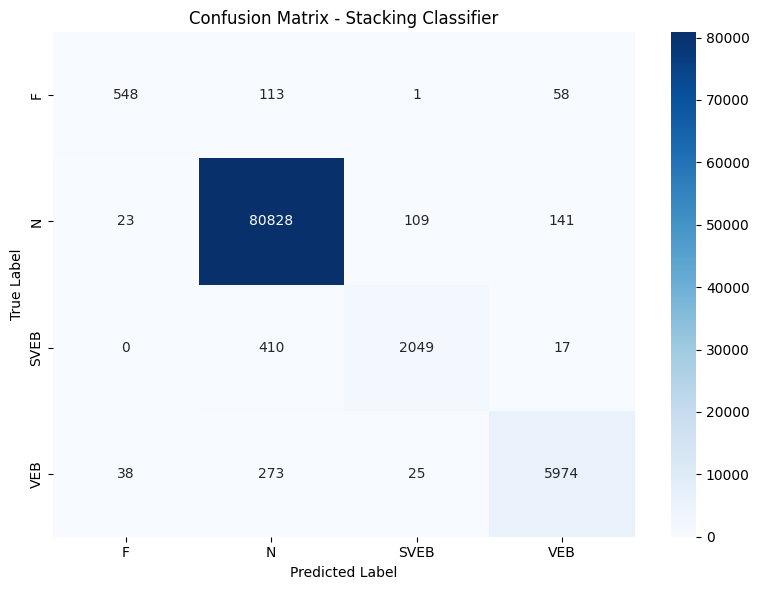

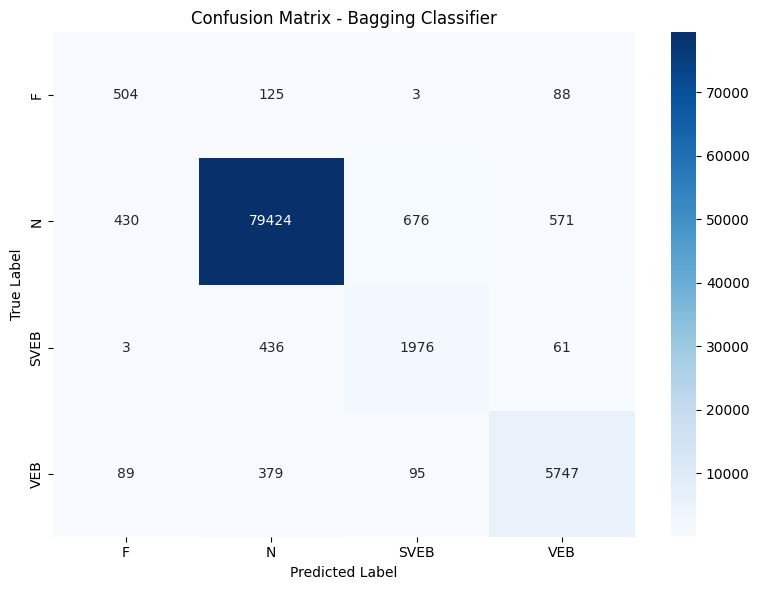

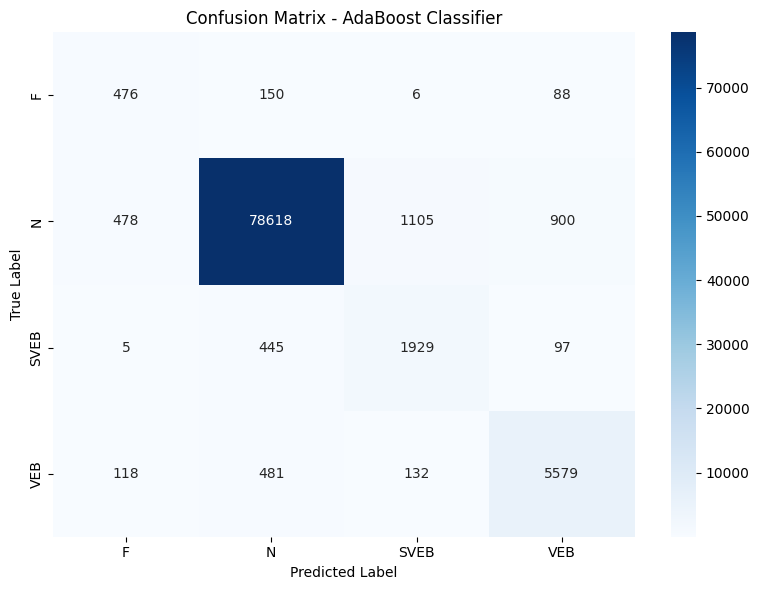

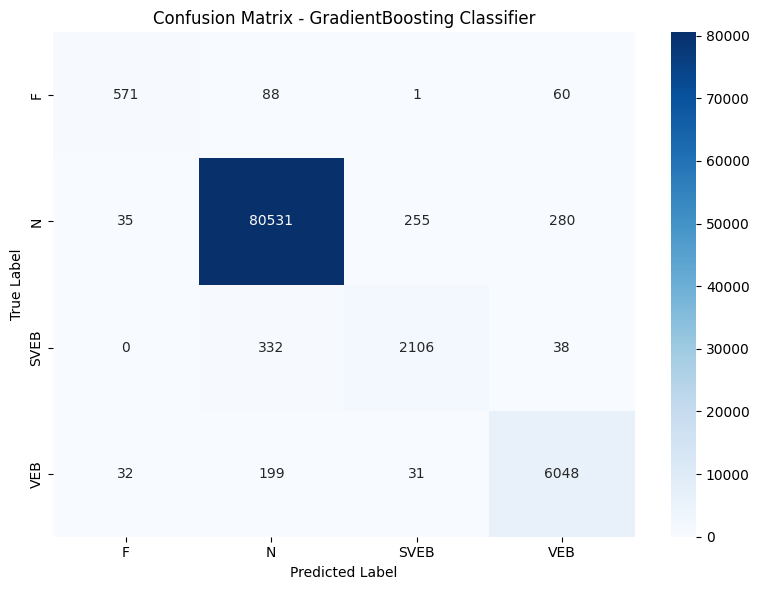

Ensemble Model Results sorted by weighted f1-score:

Stacking Classifier Results:
              precision    recall  f1-score   support

           F       0.90      0.76      0.82       720
           N       0.99      1.00      0.99     81101
        SVEB       0.94      0.83      0.88      2476
         VEB       0.97      0.95      0.96      6310

    accuracy                           0.99     90607
   macro avg       0.95      0.88      0.91     90607
weighted avg       0.99      0.99      0.99     90607

Weighted F1-Score: 0.9864

Soft Voting Results:
              precision    recall  f1-score   support

           F       0.85      0.78      0.81       720
           N       0.99      0.99      0.99     81101
        SVEB       0.88      0.88      0.88      2476
         VEB       0.95      0.96      0.95      6310

    accuracy                           0.99     90607
   macro avg       0.92      0.90      0.91     90607
weighted avg       0.99      0.99      0.99     90607



In [6]:
from sklearn.ensemble import VotingClassifier, StackingClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
ensemble_results = {}

# we are using the best 3 models to create an ensemble model, which is XGBoost, Random Forest, and KNN
# This code block is for all the ensemble models
# Create a VotingClassifier
voting_model = VotingClassifier(
    estimators=[
        ('xgb', xgb_model),
        ('rf', rf_model),
        ('knn', knn_model)
    ],
    voting='hard'  # 'hard' for majority voting, 'soft' for averaging probabilities
)

# Train the ensemble model
voting_model.fit(X_train_resampled, y_train_resampled)

# Make predictions
y_pred_voting = voting_model.predict(X_test_scaled)

# Evaluate the ensemble model
ensemble_results['Voting Classifier'] = {'report': classification_report(y_test, y_pred_voting, target_names=label_encoder.classes_),
                                        'weighted_f1': get_weighted_f1(y_test, y_pred_voting)}

plot_confusion_matrix(y_test, y_pred_voting, 'Voting Classifier', label_encoder.classes_)

# Soft Voting results
soft_voting_model = VotingClassifier(
    estimators=[
        ('xgb', xgb_model),
        ('rf', rf_model),
        ('knn', knn_model)
    ],  
    voting='soft'  # 'hard' for majority voting, 'soft' for averaging probabilities
)

# Train the soft voting model
soft_voting_model.fit(X_train_resampled, y_train_resampled) 

# Make predictions
y_pred_soft_voting = soft_voting_model.predict(X_test_scaled)

# Evaluate the soft voting model
ensemble_results['Soft Voting'] = {'report': classification_report(y_test, y_pred_soft_voting, target_names=label_encoder.classes_),
                                  'weighted_f1': get_weighted_f1(y_test, y_pred_soft_voting)}

plot_confusion_matrix(y_test, y_pred_soft_voting, 'Soft Voting', label_encoder.classes_)

# Stacking Classifier
stacking_model = StackingClassifier(
    estimators=[
        ('xgb', xgb_model),
        ('rf', rf_model),   
        ('knn', knn_model)
    ],
    final_estimator=LogisticRegression(random_state=42, max_iter=1000)
)

# Train the stacking model
stacking_model.fit(X_train_resampled, y_train_resampled)   

# Make predictions
y_pred_stacking = stacking_model.predict(X_test_scaled)

# Evaluate the stacking model
ensemble_results['Stacking Classifier'] = {'report': classification_report(y_test, y_pred_stacking, target_names=label_encoder.classes_),
                                         'weighted_f1': get_weighted_f1(y_test, y_pred_stacking)}

plot_confusion_matrix(y_test, y_pred_stacking, 'Stacking Classifier', label_encoder.classes_)

# Bagging Classifier
bagging_model = BaggingClassifier(
    estimator=DecisionTreeClassifier(random_state=42),
    n_estimators=10,
    random_state=42
)   

# Train the bagging model
bagging_model.fit(X_train_resampled, y_train_resampled)

# Make predictions
y_pred_bagging = bagging_model.predict(X_test_scaled)   

# Evaluate the bagging model
ensemble_results['Bagging Classifier'] = {'report': classification_report(y_test, y_pred_bagging, target_names=label_encoder.classes_),
                                         'weighted_f1': get_weighted_f1(y_test, y_pred_bagging)}        

plot_confusion_matrix(y_test, y_pred_bagging, 'Bagging Classifier', label_encoder.classes_)

# AdaBoost Classifier
ada_model = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(random_state=42),
    n_estimators=10,
    random_state=42
)           

# Train the AdaBoost model
ada_model.fit(X_train_resampled, y_train_resampled)

# Make predictions
y_pred_ada = ada_model.predict(X_test_scaled)

# Evaluate the AdaBoost model
ensemble_results['AdaBoost Classifier'] = {'report': classification_report(y_test, y_pred_ada, target_names=label_encoder.classes_),
                                          'weighted_f1': get_weighted_f1(y_test, y_pred_ada)}

plot_confusion_matrix(y_test, y_pred_ada, 'AdaBoost Classifier', label_encoder.classes_)

# Fine-tune parameters
gradient_model = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,  # Add randomness
    random_state=42
)

# Train the GradientBoosting model
gradient_model.fit(X_train_resampled, y_train_resampled)

# Make predictions
y_pred_gradient = gradient_model.predict(X_test_scaled)

# Evaluate the GradientBoosting model
ensemble_results['GradientBoosting Classifier'] = {'report': classification_report(y_test, y_pred_gradient, target_names=label_encoder.classes_),
                                                  'weighted_f1': get_weighted_f1(y_test, y_pred_gradient)}

plot_confusion_matrix(y_test, y_pred_gradient, 'GradientBoosting Classifier', label_encoder.classes_)

# Print the results
sorted_ensemble_results = sorted(ensemble_results.items(), key=lambda x: x[1]['weighted_f1'], reverse=True)
print("Ensemble Model Results sorted by weighted f1-score:")
for model, result in sorted_ensemble_results:
    print(f"\n{model} Results:")
    print(result['report'])
    print(f"Weighted F1-Score: {result['weighted_f1']:.4f}")




